In [28]:
import numpy as np
from numpy import abs, sqrt, log10, sin, cos, exp, cosh, tanh, log, conj, cosh, sinh
np.set_printoptions(precision=16)
from math import pi, factorial
from numpy.random import rand
from numpy.linalg import norm
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg, csc_matrix
import time
from scipy.optimize import minimize
from scipy.special import eval_hermite

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
#mpl.rcParams["figure.dpi"] = 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import pickle

from qonn_cobyla import *

from qutip import *

import matplotlib as mpl

from matplotlib import cm

from scipy.signal import argrelextrema, find_peaks, savgol_filter
from scipy.optimize import curve_fit

In [29]:
def QFI(psi):
    '''
    This function computes the quantum Fisher information of the pure state psi.
    '''
    
    # Encoding (MZ interferometer)
    psi_phi = oc.eval_rho_interf(phi, psi)
    psi_delta = oc.eval_rho_interf(phi_delta, psi)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/oc.delta**2)[0][0]

    return cost

In [30]:
def get_rho(psi):
    '''
    This function computes the density matrix of the first mode (by tracing out the emitters and the second mode).
    Input: total pure state psi.
    '''

    # We trace out the emitters
    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()
    basis_c = csc_matrix(np.eye((N_p+1)**2, dtype=np.complex128))
    basis_e = csc_matrix(np.eye(2**2, dtype=np.complex128))
    rho_c = 0 # Initialize reduced density matrix of mode 1
    for j in range(2**2):
        rho_c += sp.kron(basis_e[:, j].H, basis_c) @ rho @ sp.kron(basis_e[:, j], basis_c)

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho_c @ sp.kron(basis_2[:, j], basis_1)

    return rho_1

In [31]:
def QFI_explicit(psi):
    '''
    This function calculates the QFI of the pure state psi.
    '''

    psi_phi = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (phi[1] * setup.H_phi_ec() ), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_phi)
    
    psi_delta = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (phi_delta[1] * setup.H_phi_ec() ), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_delta)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/oc.delta**2)[0][0]

    return cost

In [32]:
def get_wigner(psi):
    '''
    This function gets the Wigner quasiprobability distribution of the pure state psi (in QuTiP).
    '''

    # We trace out the emitters
    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()
    basis_c = csc_matrix(np.eye((N_p+1)**2, dtype=np.complex128))
    basis_e = csc_matrix(np.eye(2**2, dtype=np.complex128))
    rho_c = 0 # Initialize reduced density matrix of mode 1
    for j in range(2**2):
        rho_c += sp.kron(basis_e[:, j].H, basis_c) @ rho @ sp.kron(basis_e[:, j], basis_c)

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho_c @ sp.kron(basis_2[:, j], basis_1)

    rho_1_qutip = Qobj(rho_1)
    xvec = np.linspace(-sqrt(N_p), sqrt(N_p), 200)
    W_1 = wigner(rho_1_qutip, xvec, xvec)

    return W_1

In [33]:
N_e = 2
N_c = 2
d = 2
layers_p = d
layers_m = d

phi = [0, pi/3, 0]
delta = 1e-2
phi_delta = [0, pi/3 + delta, 0]

In [34]:
file = open('data.p', 'rb')
input = pickle.load(file)
t_vec = input[0]
N_p_list = input[1]
QFI_matrix = input[2]

i_min1 = [argrelextrema(1/np.array(QFI_matrix[i_N]), np.less)[0][0] for i_N, N_p in enumerate(N_p_list)]
# Square root fit
start = 2
x = N_p_list[start:]/2
y = t_vec[i_min1][start:]
def f_fit(x, alpha, beta, gamma):
    return alpha*sqrt(x + beta) + gamma
popt, pcov = curve_fit(f_fit, x, y)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20088\737982379.py:13: RuntimeWarning: invalid value encountered in sqrt
  return alpha*sqrt(x + beta) + gamma


In [35]:
file = open('QFI_refined.p', 'rb')
input = pickle.load(file)
N_p_list = input[1]
QFI_refined = input[2]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20088\2430015086.py:65: RuntimeWarning: invalid value encountered in sqrt
  return alpha*sqrt(x + beta) + gamma
C:\Users\Usuario\AppData\Local\Temp\ipykernel_20088\2430015086.py:159: RuntimeWarning: invalid value encountered in sqrt
  return alpha*sqrt(x + beta) + gamma


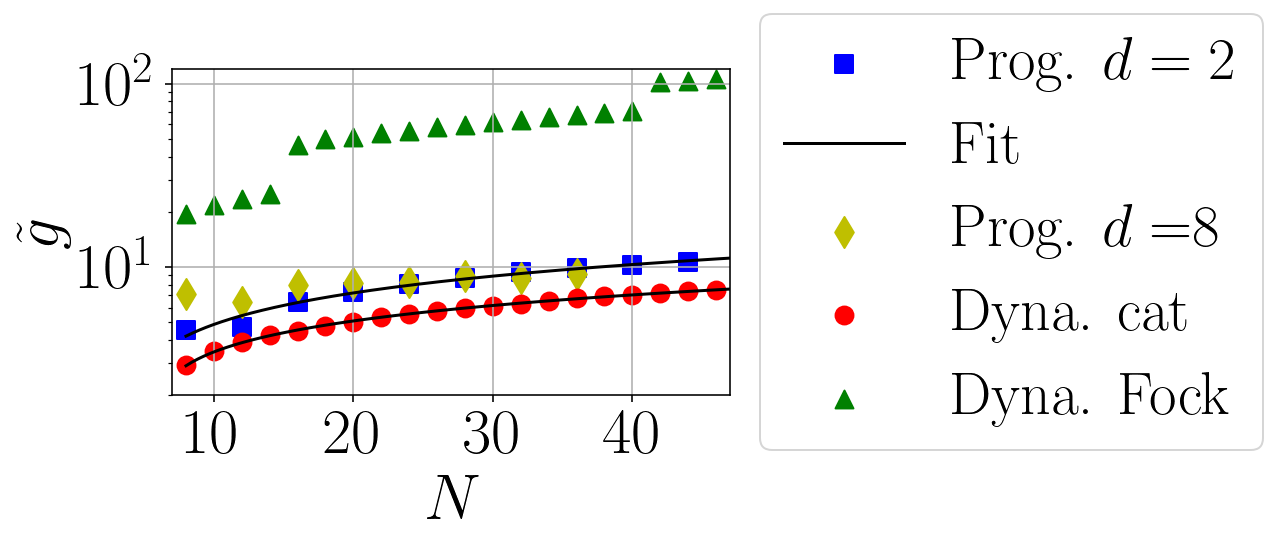

In [36]:
# We plot the results
plt.rcParams["figure.figsize"] = [5, 3]
fig, ax = plt.subplots(1, 1)
marker_size = 80
fs = 32
ax.grid()



#############################################################
# Sum of the optimal interactions in the programmable setup #
#############################################################



d = 2 # Number of layers

# Emitters, coherent initial states
with open('G:\Mi unidad\Efficient state generation for metrology\Paper v1\Figure 1 scaling optimal parameters\params_p_emitters_coherent_N_threshold_layers=2.p', 'rb') as fp:
    params_p_list = pickle.load(fp)
with open('G:\Mi unidad\Efficient state generation for metrology\Paper v1\Figure 1 scaling optimal parameters\params_m_emitters_coherent_N_threshold_layers=2.p', 'rb') as fp:
    params_m_list = pickle.load(fp)
N_p_loaded_2 = np.arange(4, 4+4*len(params_p_list), 4) # Photon threshold per cavity

Js_e_p = np.zeros((len(N_p_loaded_2), d))
Deltas_p = np.zeros((len(N_p_loaded_2), d))
gs_p = np.zeros((len(N_p_loaded_2), d))

Js_e_m = np.zeros((len(N_p_loaded_2), d))
Deltas_m = np.zeros((len(N_p_loaded_2), d))
gs_m = np.zeros((len(N_p_loaded_2), d))

for i_N, N_p in enumerate(N_p_loaded_2):

    j0 = 0
    j1 = 0
    j2 = 0

    for i in range(3*d):

        if i % 3 == 0:
            Js_e_p[i_N, j0] = params_p_list[i_N][i]
            Js_e_m[i_N, j0] = params_m_list[i_N][i]
            j0 += 1
        if i % 3 == 1:
            Deltas_p[i_N, j1] = params_p_list[i_N][i]
            Deltas_m[i_N, j1] = params_m_list[i_N][i]
            j1 += 1
        if i % 3 == 2:
            gs_p[i_N, j2] = params_p_list[i_N][i]
            gs_m[i_N, j2] = params_m_list[i_N][i]
            j2 += 1



ax.scatter(N_p_loaded_2[1::2]/2, abs(gs_p[1::2, 0]) + abs(gs_p[1::2, 1]), color='blue', s=marker_size, marker='s', label='Prog. ' + r'$d={}$'.format(d))



start = 3
x = N_p_loaded_2[start:]/2
y = abs(gs_p[start:, 0]) + abs(gs_p[start:, 1])

def f_fit(x, alpha, beta, gamma):
    return alpha*sqrt(x + beta) + gamma

popt_2, pcov_2 = curve_fit(f_fit, x, y)

x_fit = np.linspace(N_p_loaded_2[start]/2, 50, 1000)
y_fit = f_fit(x_fit, popt_2[0], popt_2[1], popt_2[2])


ax.plot(x_fit, y_fit, '-k', label='Fit')



#############################################################
# Sum of the optimal interactions in the programmable setup #
#############################################################



d = 8 # Number of layers
seeds = np.arange(1, 61, 1)
name = 'seed_jc_random_asaf_d_uptoN'

N_p_loaded = np.arange(8, 80, 8)
params_p_list = []

for i_N, N_p in enumerate(N_p_loaded):

    cost_p_matrix = []

    for seed in seeds:

        with open('G:\Mi unidad\Efficient state generation for metrology\Paper v1\Figure 7\JC photon counting data\cost_p_'+name+'_Np={}_seed={}.p'.format(int(N_p), seed), 'rb') as fp:
            input = pickle.load(fp)
            cost_p_matrix.append(input[d-1])

    index_p_min = np.argmin(cost_p_matrix)

    with open('G:\Mi unidad\Efficient state generation for metrology\Paper v1\Figure 7\JC photon counting data\params_p_'+name+'_Np={}_seed={}.p'.format(int(N_p), index_p_min+1), 'rb') as fp:
        input = pickle.load(fp)
        params_p_list.append(input[d-1])

Js_e_p = np.zeros((len(N_p_loaded), d))
Deltas_p = np.zeros((len(N_p_loaded), d))
gs_p = np.zeros((len(N_p_loaded), d))

for i_N, N_p in enumerate(N_p_loaded):

    j0 = 0
    j1 = 0
    j2 = 0

    for i in range(3*d):

        if i % 3 == 0:
            Js_e_p[i_N, j0] = params_p_list[i_N][i]
            j0 += 1
        if i % 3 == 1:
            Deltas_p[i_N, j1] = params_p_list[i_N][i]
            j1 += 1
        if i % 3 == 2:
            gs_p[i_N, j2] = params_p_list[i_N][i]
            j2 += 1

sum = 0
for i in range(d):
    sum += abs(gs_p[:, i])


ax.scatter(np.array(N_p_loaded)/2, sum, 1.5*marker_size, color='y', marker='d',\
 label=r'Prog. $d=$'+'{:}'.format(int(d)))



##########################################
# Time of first estimation error minimum #
##########################################

i_min1 = [argrelextrema(1/np.array(QFI_refined[i_N]), np.less)[0][0] for i_N, N_p in enumerate(N_p_list)]

t_min = np.zeros(len(i_min1))
for i_N, N_p in enumerate(N_p_list):
    t_guess = f_fit(N_p/2, popt[0], popt[1], popt[2])
    t_vec = np.linspace(0.8*t_guess, 1.2*t_guess, 30)
    t_min[i_N] = t_vec[i_min1[i_N]]


ax.scatter(N_p_list/2, t_min, marker_size, color='red', label='Dyna. cat')



x = N_p_list/2
y = t_min

def f_fit(x, alpha, beta, gamma):
    return alpha*sqrt(x + beta) + gamma

popt, pcov = curve_fit(f_fit, x, y)

x_fit = np.linspace(8, 50, 100)
y_fit = f_fit(x_fit, popt[0], popt[1], popt[2])


ax.plot(x_fit, y_fit, '-k')



##########################
# Uria & Hermann results #
##########################

import pandas as pd
# Read the CSV file into a DataFrame
df = pd.read_csv('plot-data.csv')
# Access data in the DataFrame using column names or indexing
N_chile = 2*np.round(np.array(list(df['x'])))
T_chile = pi*np.array(list(df[' y']))
ax.scatter(N_chile, T_chile, marker_size, color='green', marker='^', label='Dyna. Fock')


########################
# We format the figure #
########################

x_min = 7
x_max = 47



ax.set_ylabel(r'$\tilde{g}$', fontsize=fs)
ax.set_xlim(x_min, x_max)
ax.tick_params(axis='both', labelsize=fs)
ax.set_xticks(np.arange(10, 50, 10))
ax.set_xlabel(r'$N$', fontsize=fs)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs-2)



#ax.set_ylim(-0.5, 12)
#ax.set_yticks(np.arange(0, 15, 5))
#ax.set_ylim(-0.5, 20)
#ax.set_yticks(np.arange(0, 30, 10))

ax.set_yscale('log')
ax.set_ylim(2, 120)


plt.savefig('Figure 8 v2 output.svg', bbox_inches='tight', dpi=600)